<h1 style="text-align:center;">Glaucoma diagnosis using CNN</h1>

In this notebook a CNN for glaucoma diagnosis is proposed, using the RIM-ONE DL database for the training and testing datasets.

In [71]:
import tensorflow as tf
import tensorflow.keras.optimizers as opts
import tensorflow.keras.regularizers as regs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import os

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,Flatten
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array,array_to_img
from PIL import Image

### Data preprocessing and training and test sets creation:

In [2]:

def get_data(path,size):
    base_dir='C:/Users/juanc/Documents/UNAL/2021 - 2/AI para médicos/RIM-ONE_DL_images/partitioned_randomly'
    files_dir = os.path.join(base_dir,path)
    files_data = len(os.listdir(files_dir))*[None]
    i = 0

    with os.scandir(files_dir) as files:
        for file in files:
            img_path = os.path.join(files_dir,file)
            img = mimg.imread(img_path)
            img = img_to_array(img,data_format='channels_last')
            img = tf.image.resize_with_pad(img,size[0],size[1])
            files_data[i] = img
            i = i+1
    files_data = np.asarray(files_data)
    return files_data

In [45]:
train_data_glaucoma = get_data('training_set/glaucoma',[250,250])
train_data_normal = get_data('training_set/normal',[250,250])
train_data_full = np.concatenate((train_data_glaucoma,train_data_normal))

train_labels_glaucoma = np.ones((len(train_data_glaucoma),1))
train_labels_normal = np.zeros((len(train_data_normal),1))
train_labels_full = np.concatenate((train_labels_glaucoma,train_labels_normal))

#Full training set
train_data_full = np.concatenate((train_data_glaucoma,train_data_normal))
train_labels_full = np.concatenate((train_labels_glaucoma,train_labels_normal))

#Permute set to ensure presence of glaucoma and normal samples in both training and validation sets
permuted = np.random.permutation(len(train_data_glaucoma)+len(train_data_normal))
train_data_full = train_data_full[permuted]
train_labels_full = train_labels_full[permuted]

print(train_data_full.shape)
print(train_labels_full.shape)

(339, 250, 250, 3)
(339, 1)


Text(0.5, 1.0, 'Glaucoma patient retinography')

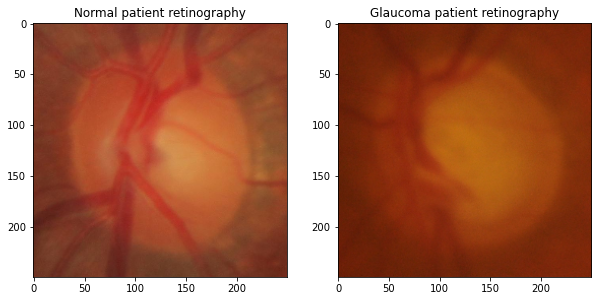

In [48]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(train_data_normal[100])
axs[0].set_title('Normal patient retinography')
axs[1].imshow(train_data_glaucoma[100])
axs[1].set_title('Glaucoma patient retinography')

#### Training set:

In [46]:
train_size = 3*(len(train_data_glaucoma)+len(train_data_normal))//4

train_data = train_data_full[:train_size]
train_labels = train_labels_full[:train_size]

print(train_data.shape)
print(train_labels.shape)

(254, 250, 250, 3)
(254, 1)


#### Validation set:

In [49]:
validation_data = train_data_full[train_size:]
validation_labels = train_labels_full[train_size:]

print(validation_data.shape)
print(validation_labels.shape)

(85, 250, 250, 3)
(85, 1)


#### Test set:

In [5]:
test_data_glaucoma = get_data('test_set/glaucoma',[250,250])
test_data_normal = get_data('test_set/normal',[250,250])
test_data = np.concatenate((test_data_glaucoma,test_data_normal))
print(test_data.shape)

test_labels_glaucoma = np.ones((len(test_data_glaucoma),1))
test_labels_normal = np.zeros((len(test_data_normal),1))
test_labels = np.concatenate((test_labels_glaucoma,test_labels_normal))
print(test_labels.shape)

(146, 250, 250, 3)
(146, 1)


### CNN design:

In [76]:
# model = Sequential([
#     Conv2D(16,(3,3),input_shape=train_data[0].shape,activation='relu',padding='same',name='conv1'),
#     Conv2D(16,(3,3),activation='relu',padding='same',name='conv2'),
#     MaxPooling2D((2,2),name='mp1'),
#     Conv2D(32,(3,3),activation='relu',padding='same',name='conv3'),
#     Conv2D(32,(3,3),activation='relu',padding='same',name='conv4'),
#     MaxPooling2D((2,2),name='mp2'),
#     BatchNormalization(name='batch_norm1'),
#     Conv2D(64,(3,3),activation='relu',padding='same',name='conv5'),
#     MaxPooling2D((2,2),name='mp3'),
#     Conv2D(64,(3,3),activation='relu',padding='same',name='conv6'),
#     MaxPooling2D((2,2),name='mp4'),
#     Flatten(name='flatten'),
#     Dense(1,activation='sigmoid',name='output'),
# ])

# model.summary()

input_img = Input((250,250,3),name='input')
x = Conv2D(16,(3,3),activation='relu',padding='same',name='conv1')(input_img)
x = Conv2D(16,(3,3),activation='relu',padding='same',name='conv2')(x)
x = MaxPooling2D((2,2),name='mp1')(x)
x = Conv2D(32,(3,3),activation='relu',padding='same',name='conv3')(x)
x = Conv2D(32,(3,3),activation='relu',padding='same',name='conv4')(x)
x = MaxPooling2D((2,2),name='mp2')(x)
x = BatchNormalization(name='batch_norm1')(x)
x = Conv2D(64,(3,3),activation='relu',padding='same',name='conv5')(x)
x = MaxPooling2D((2,2),name='mp3')(x)
x = Conv2D(64,(3,3),activation='relu',padding='same',name='conv6')(x)
x = MaxPooling2D((2,2),name='mp4')(x)
x = Flatten(name='flatten')(x)
output = Dense(1,activation='sigmoid',name='output')(x)

model = Model(inputs=input_img,outputs=output,name='Glaucoma_model')

model.summary()

Model: "Glaucoma_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 250, 250, 16)      448       
_________________________________________________________________
conv2 (Conv2D)               (None, 250, 250, 16)      2320      
_________________________________________________________________
mp1 (MaxPooling2D)           (None, 125, 125, 16)      0         
_________________________________________________________________
conv3 (Conv2D)               (None, 125, 125, 32)      4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 125, 125, 32)      9248      
_________________________________________________________________
mp2 (MaxPooling2D)           (None, 62, 62, 32)     

In [77]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [78]:
class TrainingCallback(Callback):
    def on_train_begin(self,logs=None):
        print('Starting training...')
        
    def on_epoch_begin(self,epoch,logs=None):
        print(f"Starting epoch {epoch+1}")
        
    def on_epoch_end(self,epoch,logs=None):
        print(f"Finished epoch {epoch+1}")
        
    def on_train_end(self,logs=None):
        print('Finished training')

checkpoint_path = 'C:/Users/juanc/Documents/UNAL/2021 - 2/AI para médicos/cnn_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path,frequency='epoch',save_weights_only=1,
                            save_best_only=1,verbose=1,monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=1e-3,patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2,verbose=1,min_delta=1e-3)

In [79]:
history = model.fit(train_data,train_labels,epochs=20,batch_size=32,
                    validation_data=(validation_data,validation_labels),verbose=2,
                    callbacks=[checkpoint,TrainingCallback(),early_stopping,reduce_lr])

Starting training...
Starting epoch 1
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.68235, saving model to C:/Users/juanc/Documents/UNAL/2021 - 2/AI para médicos/cnn_checkpoints\checkpoint
Finished epoch 1
8/8 - 104s - loss: 0.6465 - accuracy: 0.6535 - val_loss: 0.6839 - val_accuracy: 0.6824
Starting epoch 2
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.68235
Finished epoch 2
8/8 - 78s - loss: 0.5173 - accuracy: 0.7205 - val_loss: 0.6765 - val_accuracy: 0.6824
Starting epoch 3
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.68235
Finished epoch 3

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8/8 - 87s - loss: 0.4597 - accuracy: 0.7717 - val_loss: 0.6758 - val_accuracy: 0.6471
Starting epoch 4
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.68235 to 0.81176, saving model to C:/Users/juanc/Documents/UNAL/2021 - 2/AI para médicos/cnn_checkpoints\checkpoint
Finished epoch 4
8/8 - 80s - loss: 0.3632 - accur

Text(0, 0.5, 'Loss')

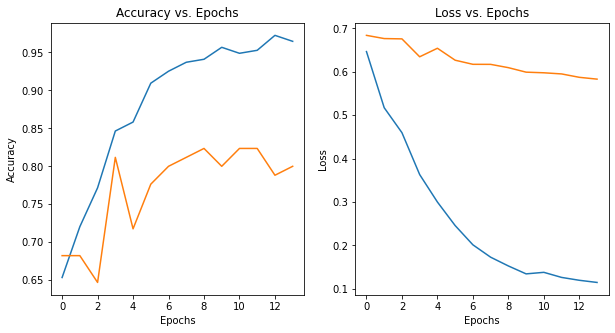

In [80]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(train_acc)
ax[0].plot(val_acc)
ax[0].set_title('Accuracy vs. Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(train_loss)
ax[1].plot(val_loss)
ax[1].set_title('Loss vs. Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

Now, we explore the filters generated in each layer of our model for one of the training images:

In [81]:
layers_output = [layer.output for layer in model2.layers]
model3 = Model(inputs=model2.input,outputs=layers_output)

In [82]:
aux_img = np.expand_dims(test_data[22],0)
extracted_features = model3(aux_img)


 shape:  (1, 62, 62, 64)


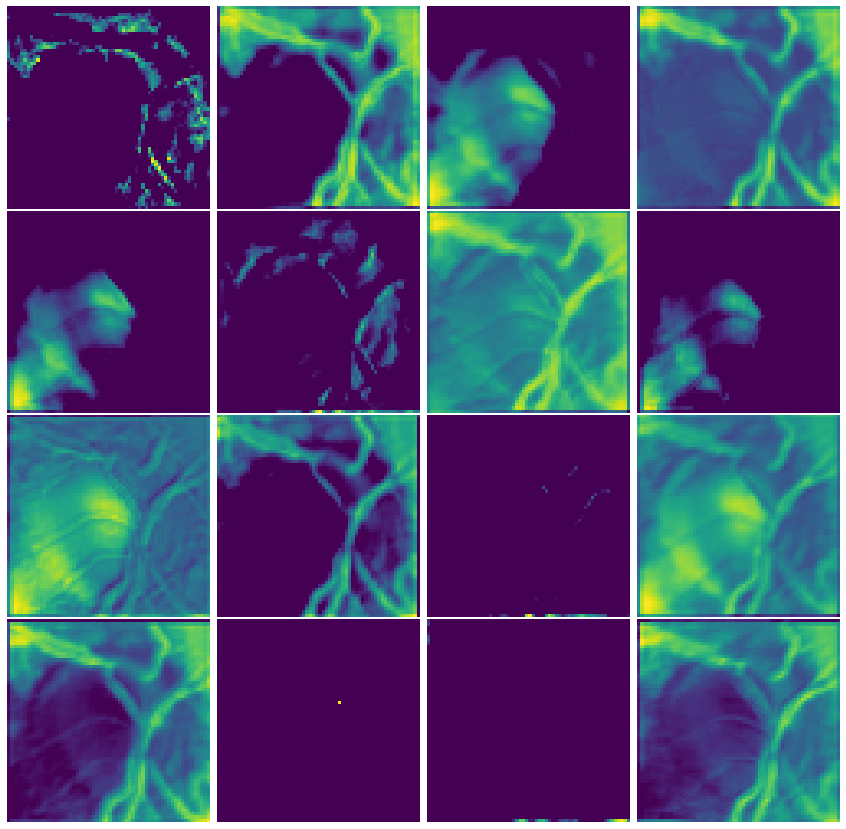

In [83]:
f1 = extracted_features[8] #conv5 layer
print('\n shape: ',f1.shape)

imgs = f1[0,:,:]
plt.figure(figsize=(15,15))
for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(imgs[:,:,n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [90]:
model.evaluate(test_data,test_labels,batch_size=32,verbose=2)

5/5 - 6s - loss: 0.5626 - accuracy: 0.8836


[0.5626416802406311, 0.8835616707801819]

In [95]:
predictions = model.predict(test_data,batch_size=32,verbose=2)

5/5 - 6s


In [94]:
print(np.round(predictions[45:60].T))
print(test_labels[45:60].T)

[[1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
